<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Analysis/Twitter_multimodal_classifier_MHA_Luong_Regularized_Analysis_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.2 MB/s eta 0:00:00


In [2]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/twitter-models/'

## Load the dataframes

In [5]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-train.pickle")
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(14258, 3) (1923, 3)


# Data input pipeline

In [6]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [7]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [8]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_word_ids': (None  0         
                             , 128),                             
                              'input_type_ids': (None            
                             , 128),                             
                              'input_mask': (None, 12            
                             8)}                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: just a crazy thought... #hurricanesandy http://t.co/uGoa7itw
Text 2: just a crazy thought... #hurricanesandy http://t.co/uGoa7itw
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2074  1037  4689  2245  1012  1012  1012  1001 17035  5685  2100
  8299  1024  1013  1013], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [10]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [11]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [12]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [13]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [14]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [15]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [16]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [17]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [18]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [19]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

### Text Encoder

In [20]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

### Multi Head Attention Layer

In [21]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, y, training):
        attn_output = self.att(x, y)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## MultiModal model

In [22]:
def create_multimodal_model(
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    
    # Cross-attention.
    if attention:
      transformer_block = TransformerBlock(projection_dims, 4, projection_dims)
      x = transformer_block(tf.expand_dims(vision_projections, -1), tf.expand_dims(text_projections, -1))
      x = tf.keras.layers.Flatten()(x)
      x = project_embeddings(
        x, 1, projection_dims, dropout_rate) 
      query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
            [vision_projections, text_projections]
        )
      
    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    if attention:
        concatenated = keras.layers.Concatenate()([concatenated, x, query_value_attention_seq])
        #x = tf.keras.layers.Flatten(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)

In [23]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [24]:
checkpoint_filepath = '/content/drive/MyDrive/multimodal-news/twitter-models-1/model-comb1-weights.{val_accuracy:.4f}-{val_loss:.2f}.hdf5'
save_model1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [25]:
multimodal_model = create_multimodal_model(attention=True, num_projection_layers=0, projection_dims=128, dropout_rate=0.2)

52606240/52606240 [==============================] - 2s 0us/step


### Model Training

In [26]:
epochs = 10
batch_size = 32

In [ ]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 73s 128ms/step - loss: 0.2429 - accuracy: 0.8957 - precision: 0.8697 - recall: 0.8514 - val_loss: 0.4157 - val_accuracy: 0.8159 - val_precision: 0.7993 - val_recall: 0.9437
Epoch 2/10
446/446 [==============================] - 54s 122ms/step - loss: 0.2352 - accuracy: 0.9055 - precision: 0.8822 - recall: 0.8369 - val_loss: 0.3766 - val_accuracy: 0.8471 - val_precision: 0.8536 - val_recall: 0.9130
Epoch 3/10
446/446 [==============================] - 55s 124ms/step - loss: 0.2226 - accuracy: 0.9111 - precision: 0.8927 - recall: 0.8430 - val_loss: 0.3764 - val_accuracy: 0.8721 - val_precision: 0.9256 - val_recall: 0.8658
Epoch 4/10
446/446 [==============================] - 55s 123ms/step - loss: 0.2168 - accuracy: 0.9144 - precision: 0.8961 - recall: 0.8495 - val_loss: 0.4027 - val_accuracy: 0.8315 - val_precision: 0.8278 - val_recall: 0.9238
Epoch 5/10
446/446 [==============================] - 55s 123ms/step - loss: 0.2185 - accura

In [30]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [31]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
y_pred = multimodal_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 9s 93ms/step
Accuracy == 0.8341133645345814
F1 == [0.77000721 0.87027247]
Precision == [0.79582712 0.85463259]
Recall == [0.74581006 0.88649544]


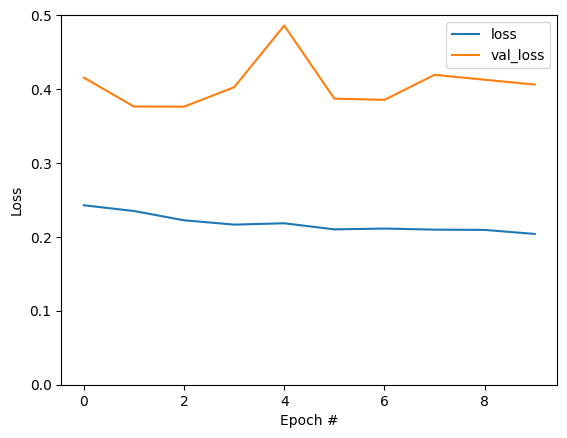

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs tersting accuracy

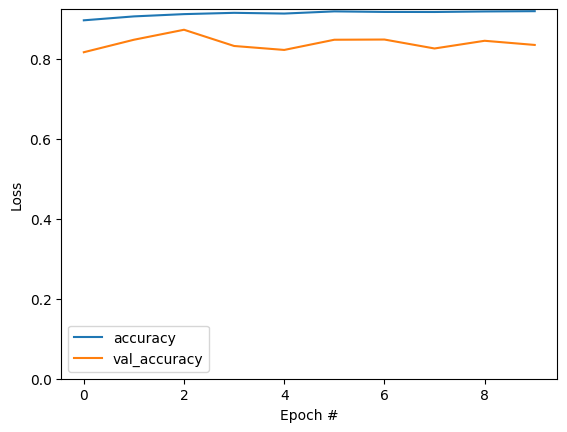

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [32]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

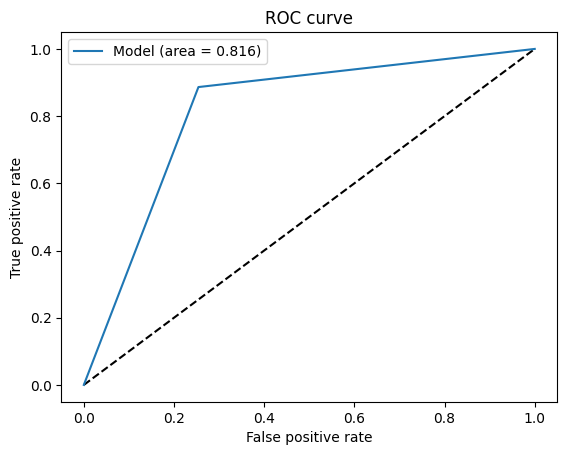

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
multimodal_model = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=128, dropout_rate=0.2)

### Model Training

In [ ]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 75s 127ms/step - loss: 0.5390 - accuracy: 0.7540 - precision: 0.7113 - recall: 0.5870 - val_loss: 0.4092 - val_accuracy: 0.8092 - val_precision: 0.8102 - val_recall: 0.9089
Epoch 2/10
446/446 [==============================] - 55s 123ms/step - loss: 0.3696 - accuracy: 0.8413 - precision: 0.7934 - recall: 0.7282 - val_loss: 0.3635 - val_accuracy: 0.8757 - val_precision: 0.9040 - val_recall: 0.8973
Epoch 3/10
446/446 [==============================] - 55s 122ms/step - loss: 0.3156 - accuracy: 0.8673 - precision: 0.8289 - recall: 0.7741 - val_loss: 0.3884 - val_accuracy: 0.8700 - val_precision: 0.9045 - val_recall: 0.8865
Epoch 4/10
446/446 [==============================] - 55s 123ms/step - loss: 0.2871 - accuracy: 0.8778 - precision: 0.8393 - recall: 0.7973 - val_loss: 0.4348 - val_accuracy: 0.8638 - val_precision: 0.9428 - val_recall: 0.8335
Epoch 5/10
446/446 [==============================] - 55s 123ms/step - loss: 0.2544 - accura

In [96]:
multimodal_model = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=128, dropout_rate=0.1)

### Model Training

In [97]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=6, batch_size=batch_size)

Epoch 1/6
446/446 [==============================] - 76s 129ms/step - loss: 0.4750 - accuracy: 0.7754 - precision: 0.7393 - recall: 0.6260 - val_loss: 0.4235 - val_accuracy: 0.7988 - val_precision: 0.7847 - val_recall: 0.9362
Epoch 2/6
446/446 [==============================] - 54s 121ms/step - loss: 0.3492 - accuracy: 0.8551 - precision: 0.8129 - recall: 0.7519 - val_loss: 0.3701 - val_accuracy: 0.8778 - val_precision: 0.9050 - val_recall: 0.8998
Epoch 3/6
446/446 [==============================] - 54s 121ms/step - loss: 0.3048 - accuracy: 0.8739 - precision: 0.8369 - recall: 0.7867 - val_loss: 0.3359 - val_accuracy: 0.8778 - val_precision: 0.8977 - val_recall: 0.9089
Epoch 4/6
446/446 [==============================] - 54s 122ms/step - loss: 0.2816 - accuracy: 0.8836 - precision: 0.8508 - recall: 0.8022 - val_loss: 0.3426 - val_accuracy: 0.8830 - val_precision: 0.9119 - val_recall: 0.9006
Epoch 5/6
446/446 [==============================] - 54s 121ms/step - loss: 0.2473 - accuracy: 0

In [98]:
y_pred = multimodal_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 9s 96ms/step
Accuracy == 0.8663546541861674
F1 == [0.83493899 0.8877239 ]
Precision == [0.77288942 0.93900185]
Recall == [0.90782123 0.84175642]


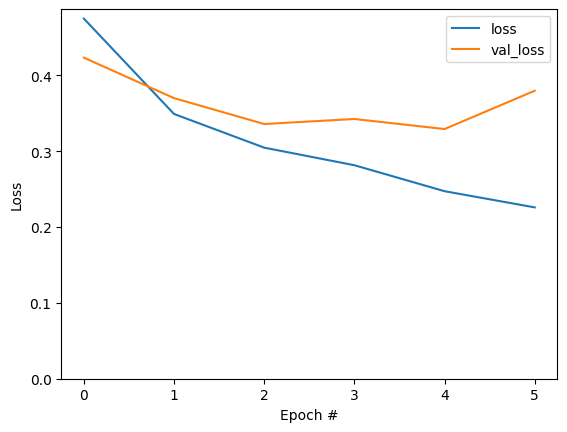

In [99]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs tersting accuracy

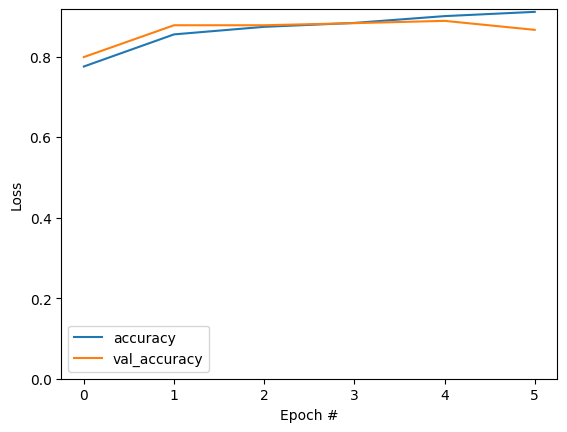

In [100]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [101]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

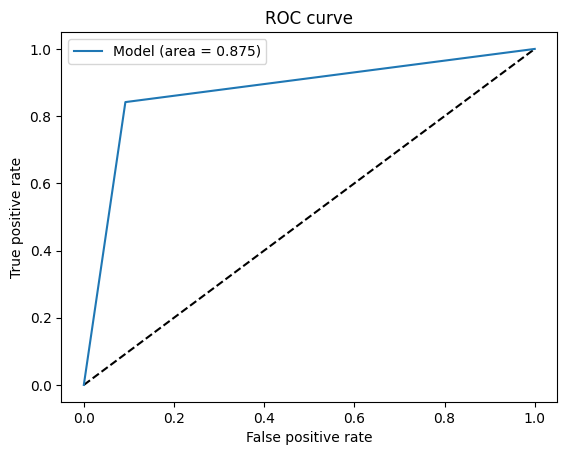

In [102]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# t-SNE visulaization

In [103]:
model2 = tf.keras.Model(inputs=multimodal_model.input, outputs=multimodal_model.layers[-2].output)
features = model2.predict(test_ds)

61/61 [==============================] - 9s 96ms/step


In [104]:
from sklearn.manifold import TSNE

In [105]:
labels = y_pred
tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

In [106]:
def scale_to_01_range(x):
  value_range = (np.max(x) - np.min(x))
  starts_from_zero = x - np.min(x)
  return starts_from_zero / value_range

In [107]:
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [108]:
colors = ['red', 'blue']
classes = ['fake', 'real']
print(classes)

['fake', 'real']


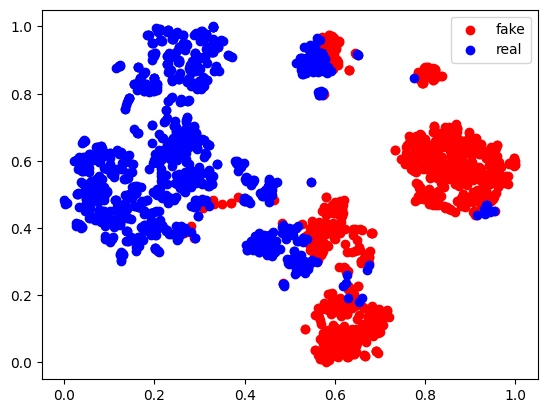

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors):
    indices = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

ax.legend(loc='best')
plt.show()